In [1]:
import os
import pickle
import pystan
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import multiprocessing
import itertools as it
from scipy.special import expit

In [2]:
multiprocessing.set_start_method("fork")
sns.set()  # Nice plot aesthetic

In [3]:
bkp_folder = 'bkp'
os.makedirs(bkp_folder, exist_ok=True)

In [4]:
# Set seed
np.random.seed(123)

# Generate data

In [5]:
def f(x):
    """The function to predict."""
    return x * np.sin(x)


x = np.linspace(0, 10, 100)

# Observations and noise
y = f(x)
dy = 0.5 + 1.0 * np.random.random(y.shape)
noise = np.random.normal(0, dy)
y += noise

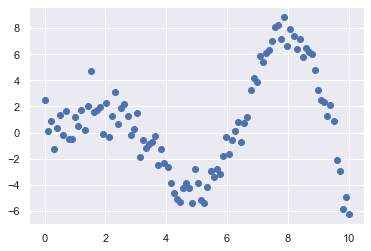

In [6]:
plt.scatter(x, y)
plt.show()

# Stan-GP

Note: in Stan language, vector indexes start from 1 (unlike Python thats starts from 0) 

In [7]:
model = """
data {
  int<lower=1> N1;
  real x1[N1];
  vector[N1] y1;
  int<lower=1> N2;
  real x2[N2];
}
transformed data {
  // real delta = 1e-9;
  int<lower=1> N = N1 + N2;
  real x[N];
  for (n1 in 1:N1) x[n1] = x1[n1];
  for (n2 in 1:N2) x[N1 + n2] = x2[n2];
}
parameters {
  real<lower=0> rho;
  real<lower=0> alpha;
  real<lower=0> sigma;
  vector[N] eta;
}
transformed parameters {
  vector[N] f;
  {
    matrix[N, N] K = cov_exp_quad(x, alpha, rho) + diag_matrix(rep_vector(1e-9, N));
    matrix[N, N] L_K = cholesky_decompose(K);
    f = L_K * eta;
  }
}
model {
  rho ~ normal(0, 3); //inv_gamma(5, 5);
  alpha ~ normal(0, 1);
  sigma ~ normal(0, 1);
  eta ~ normal(0, 1);

  y1 ~ normal(f[1:N1], sigma);
}
generated quantities {
  vector[N2] y2;
  for (n2 in 1:N2)
    y2[n2] = normal_rng(f[N1 + n2], sigma);
}
"""

### Compile the model

*Note: Set `force_compilation = False` to avoid the (quite long) compilation of the model if you didn't make any change since the last compilation*

In [8]:
# Put it to true if you edit the model
force_compilation = False

# Where to save backup
bkp_folder = 'bkp'
os.makedirs(bkp_folder, exist_ok=True)
bkp_file = os.path.join(bkp_folder, 'gp_model.pkl')

if not os.path.exists(bkp_file) or force_compilation is True:
    
    # Compile the model
    sm = pystan.StanModel(model_code=model)
    
    # Save the model
    with open(bkp_file, 'wb') as f:
        pickle.dump(sm, f)
else:
    # Load the model
    sm = pickle.load(open(bkp_file, 'rb'))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1b63c7af48dc08a2a36eb1b05bba9305 NOW.


### Sampling

* `iter`: number of samples that will be generated from each Markov chain.
* `chains`: number of chains from which samples will be combined to form the posterior distribution. Because the underlying Markov process is stochastic, it's advantageous to have more chains that will initialise at different locations in parameter space, though adding more chains will increase the amount of time it takes to sample. 
* `warmup` (also known as 'burn-in'): number of samples that will be discarded from the beginning of each chain. As the early samples will be drawn when the Markov chain hasn't had a chance to reach equilibrium. By default this is half of iter, so for each chain we'll get 1000 samples, and chuck away the first 500. With 4 chains, we'll have 2000 samples in total.
* `thin`: interval in sampling at which samples are retained. E.g.: if thin is set to 3, every third sample is retained and the rest are discarded. This can be necessary to mitigate the effect of correlation between successive samples. If thin is set to 1 (like here), every sample is retained. 
* `seed`: Seed for the random generator. It allows for reproducibility.

In [9]:
x_pred_stan = np.linspace(0, 10, 100)

In [ ]:
# Put it to true if you want to do a new run
force_run = False

# Where to save backup
bkp_file = os.path.join(bkp_folder, 'gp_fit.pkl')

if not os.path.exists(bkp_file) or force_run is True:
    
    # Train the model and generate samples
    fit_stan = sm.sampling(data={'N1': len(x), 'x1': x, 'y1': y, 'N2': len(x_pred_stan), 'x2': x_pred_stan}, 
                           iter=1000, chains=1, ) #algorithm="Fixed_param")
    
    # Save
    with open(bkp_file, 'wb') as f:
        pickle.dump(fit_stan, f)
else:
    # Load
    fit_stan = pickle.load(open(bkp_file, 'rb'))

fit_stan

In [ ]:
# Cast the fit output to a pandas DataFrame
summary_dict = fit_stan.summary()
df = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])
df

In [ ]:
x_pred = x_pred_stan
y_pred = np.array([df.loc[f"y2[{i}]", "mean"] for i in range(1, len(x_pred)+1)])
sigma = np.array([df.loc[f"y2[{i}]", "sd"] for i in range(1, len(x_pred)+1)])
ex = fit_stan.extract()
y_samples = ex["y2"].T[:, np.random.randint(len(x_pred), size=10)]

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(x_pred, f(x_pred), 'r:', label=r'$f(x) = x\,\sin(x)$')
plt.scatter(x, y, color='r', s=10, label='Observations')
plt.plot(x_pred, y_pred, 'b-', label='Prediction')
plt.fill_between(x_pred, y_pred + 1.96 * sigma, y_pred - 1.96 * sigma,
                 alpha=.2, fc='blue', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 10)
plt.legend(loc='upper left')

plt.plot(x_pred, y_samples, lw=0.5, color='blue')

plt.tight_layout()
plt.show()

\begin{equation}
k(x) = \alpha^2\exp\left(-\frac{1}{2\rho^2}(x_i-x_j)^2\right) + \delta_{i,j}\sigma^2
\end{equation}
where $\delta_{i,j}$ is the Kronecker delta function (1 if $i=j$, 0 otherwise).

The addition of $\sigma^2$ on the diagonal is important to ensure the positive definiteness of the resulting matrix in the case of two identical inputs $x_i = x_j$. In statistical terms, $\sigma$ is the scale of the noise term in the regression.

The hyperparameter $\rho$ is the length-scale, and corresponds to the frequency of the functions represented by the Gaussian process prior with respect to the domain. Values of $\rho$ closer to zero lead the GP to represent high-frequency functions, whereas larger values of $\rho$ lead to low-frequency functions.

The hyperparameter $\alpha$ is the marginal standard deviation. It controls the magnitude of the range of the function represented by the GP. If you were to take the standard deviation of many draws from the GP $f_1$ prior at a single input $x$ conditional on one value of $\alpha$ one would recover $\alpha$.